# 2 qubit GST for XYICZ gate: Testing random sequence constructions

In [1]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [2]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt
from random import sample
#from pygsti.modelpacks import smq2Q_XYICNOT as std

%run ../src/mGST/reporting.py

### Setting the parameters

In [3]:
pdim = 4   # physical dimension
r = pdim**2   # rank of the gate superoperators 

max_l = 10  # maximum number of gates in each measurement sequence
n_povm = 4   # number of POVM-elements
d = 6

In [4]:
from true_values import E_true, X_true, rho_true
X_t = X_true[:d].copy()
E_t = E_true.copy()
rho_t = rho_true.copy()
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std')
noisy_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std').depolarize(0.001,spam_noise=0.05).randomize_with_unitary(0.01)
X_noisy, E_noisy, rho_noisy = compatibility.pygsti_model_to_arrays(noisy_mdl, basis = 'std')

### Generating data

In [5]:
def random_len_seq_2(d,min_l,max_l,N):
    seq_lengths = np.sort(np.random.randint(min_l,max_l+1,N))
    J = []
    for l in seq_lengths:
        j_curr = np.random.randint(0,d,l)
        J.append(list(np.pad(j_curr,(0,max_l-l),'constant',constant_values=-1)))
    return np.array(J)

def random_len_seq_3(d,min_l,max_l,N): #Draws without replacement but inneficiently (not working for sequences length > 24)
    seq_counts = []
    J = [-np.ones(max_l)]
    N_remaining = N - 1
    for l in range(min_l,max_l+1):
        seq_counts.append(int(np.min([np.floor(N_remaining/(max_l+1-l)), d**l])))
        ind_curr = np.array(sample(range(d**l), seq_counts[-1]))
        J_curr = np.array([np.pad(low_level_jit.local_basis(ind,d,l),(0,max_l-l),'constant', constant_values = -1) for ind in ind_curr])
        J = np.concatenate((J,J_curr), axis = 0)
        N_remaining = N - 1 - np.sum(seq_counts)
    if N_remaining > 0:
        print('Number of possible sequences without replacement for the given sequence\
        length range is lower than the desired total number of sequences')
    return J.astype(int)

In [6]:
J = random_len_seq_3(d,1,8,500)

In [7]:
print(J.shape)

(500, 8)


In [8]:
l_min = 1
l_cut = 8
l_max = 24
N = 500
N_long = 300
meas_samples = 1e5
J = random_len_seq_3(d,l_min,l_cut,N)
J2 = random_len_seq_3(d,l_cut,l_max,N_long)

y = np.real(np.array([[E_noisy[i].conj()@low_level_jit.contract(X_noisy,j)@rho_noisy for j in J] for i in range(n_povm)]))
y = additional_fns.sampled_measurements(y,meas_samples).copy()

y2 = np.real(np.array([[E_noisy[i].conj()@low_level_jit.contract(X_noisy,j)@rho_noisy for j in J2] for i in range(n_povm)]))
y2 = additional_fns.sampled_measurements(y2,meas_samples).copy()

In [9]:
max_l_drawn = np.max(np.sum(J2>=0,axis = 1))
print(max_l_drawn)
J_all = []
for i in range(N):
    J_all.append(list(np.pad(J[i],(0,max_l_drawn-len(J[i])),'constant',constant_values=-1)))
for i in range(N_long):
    J_all.append(list(np.pad(J2[i],(0,max_l_drawn-len(J2[i])),'constant',constant_values=-1)))
J_all = np.array(J_all)

J_reduced = []
for i in range(N):
    J_reduced.append(list(J[i,:][J[i,:]>=0]))
for i in range(N_long):
    J_reduced.append(list(J2[i,:][J2[i,:]>=0]))
y_all = np.concatenate((y,y2), axis = 1)

24


In [10]:
print(y_all.shape)

(4, 800)


In [11]:
import csv

# with open('sequences.csv', 'w', newline='') as myfile:
#    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#    wr.writerows(J_reduced)

### Loading data

In [5]:
# Hardware probabilities
filename = 'data/20230525-1313_cgst_2q.json'

with open(filename) as f:
    data = json.load(f)
    
#N = data['nsequences']
N = len(data['measurements']) 
print('Number of sequences ', N)


def get_hardware_probability(probs, key):
    # returns 0 for missing keys
    if key in probs:
        return probs[key]
    else:
        return 0


max_l = 0
for entry in data['measurements']:
#    print(entry['circuit'])
#    print(entry['hardware_probabilities'])
    if len(entry['circuit']) > max_l:
        max_l = len(entry['circuit'])
print('Max length', max_l)

# Zero pad and turn around circuits
J_all = np.array([list(np.pad(np.int64(data['measurements'][i]['circuit']),(0,max_l-len(data['measurements'][i]['circuit'])),'constant',constant_values=-1)) for i in range(N)])[:,::-1]



y_all = np.array([[
    get_hardware_probability(data['measurements'][i]['hardware_probabilities'],basis_str) for i in range(N)] for basis_str in ['00','01','10','11']])

y_all_ideal = np.array([[
    get_hardware_probability(data['measurements'][i]['simulation_probabilities'],basis_str) for i in range(N)] for basis_str in ['00','01','10','11']])


meas_samples = data['nshots']

# adjust threshold_multiplier if convergence is not reached


J = J_all[:500]
y = y_all[:,:500]


Number of sequences  799
Max length 24


In [28]:
# Check types
print(y_all.shape)
print(type(J_all))
print(type(J_all[0]))
print(type(J_all[0][0]))
print(type(y_all))
print(type(y_all[0]))
print(type(y_all[0][0]))

(4, 799)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.int64'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>


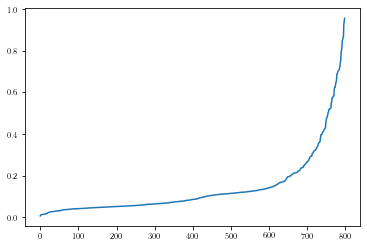

of which do not contain 0
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]
[0.28660826032540676, 0.24603174603174602, 0.2540983606557377, 0.18716577540106952, 0.16901408450704225, 0.1509433962264151, 0.16279069767441862, 0.14285714285714285, 0.15, 0.18, 0.20454545454545456, 0.2222222222222222, 0.17857142857142858, 0.13636363636363635, 0.16666666666666666, 0.2727272727272727, 0.2222222222222222, 0.2857142857142857, 0.6666666666666666, 1.0]


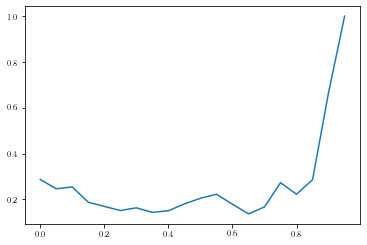

[[-1 -1 -1 ...  5  5  3]
 [-1 -1 -1 ...  5  4  5]
 [-1 -1 -1 ...  5  1  4]
 ...
 [ 3  1  5 ...  3  2  3]
 [ 3  4  5 ...  4  4  0]
 [ 2  5  0 ...  2  3  4]]
[[0.9505 0.3995 0.1972 0.9346 0.2601 0.279  0.0897 0.1666 0.0709 0.0316
  0.1717 0.3676 0.1075 0.3824 0.1737 0.3249 0.2035 0.7586 0.2485 0.2833
  0.2785 0.3222 0.506  0.1106 0.1846 0.3755 0.7346 0.2748 0.1181 0.3301
  0.0917 0.4308 0.591  0.2818 0.304  0.6262 0.567  0.3544 0.764  0.2171
  0.4578 0.2848 0.3913 0.147 ]
 [0.0438 0.1449 0.1356 0.0591 0.2942 0.2814 0.671  0.391  0.4713 0.1004
  0.3865 0.0849 0.0798 0.1758 0.508  0.2121 0.4191 0.1033 0.3038 0.3122
  0.1219 0.2335 0.4231 0.1038 0.406  0.1306 0.0708 0.1191 0.3587 0.2947
  0.3792 0.1265 0.1139 0.601  0.159  0.2444 0.073  0.3556 0.0923 0.2756
  0.0791 0.1677 0.1502 0.1732]
 [0.0047 0.3312 0.4505 0.0049 0.2211 0.2004 0.0412 0.2161 0.0828 0.1817
  0.1303 0.4265 0.5017 0.0659 0.2339 0.1851 0.1473 0.0828 0.3209 0.1643
  0.1709 0.2496 0.0373 0.6399 0.2601 0.1625 0.0448 0.1416 0.09

In [41]:
# Calculate TV distance to ideal probabilities
deviations = np.sum(np.abs(y_all - y_all_ideal), axis=0)/2
plt.plot(np.sort(deviations))
plt.show()



thress = np.arange(0,1,.05)

#print(J_all[deviations > thress].shape)

print('of which do not contain 0')
ratios = [np.sum(np.logical_not(np.any(np.isin(J_all[deviations > thres], [0]), axis=1))) / J_all[deviations > thres].shape[0]
for thres in thress]

print(thress)
print(ratios)

plt.plot(thress, ratios)
plt.show()

print(J_all[deviations > .5])
print(y_all[:,deviations > .5])
print(y_all_ideal[:,deviations > .5])




## Sequence Cleanup

In [6]:
# Calculate TV distance to ideal probabilities
deviations = np.sum(np.abs(y_all[:,:500] - y_all_ideal[:,:500]), axis=0)/2
thress = 0.2

print(J_all[:500][deviations < thress].shape)
print(y_all[:,:500][:,deviations < thress].shape)

J_clean = J_all[:500][deviations < thress]
y_clean = y_all[:,:500][:,deviations < thress]

(470, 24)
(4, 470)


In [7]:
# Calculate TV distance to ideal probabilities
deviations = np.sum(np.abs(y_all - y_all_ideal), axis=0)/2
thress = 0.2

print(J_all[deviations < thress].shape)
print(y_all[:,deviations < thress].shape)

J_all_clean = J_all[deviations < thress]
y_all_clean = y_all[:,deviations < thress]

(657, 24)
(4, 657)


### GST

In [ ]:
bsize = 120   # The batch size on which the optimization is started
results = []
rK = 16
for _ in range(1): # repeat multiple time or by using max_inits
    K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
    K,X,E,rho,res_list = algorithm.run_mGST(y_clean, J_clean, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'GD',
                         max_inits = 10, max_iter = 150, final_iter = 20, threshold_multiplier = 15, 
                         target_rel_prec = 1e-4, init = [K_t, E_t, rho_t], fixed_elements = ['rho'], testing = True)   
    K2,X2,E2,rho2,res_list2 = algorithm.run_mGST(y_all_clean,J_all_clean, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'GD',
                         max_inits = 1, max_iter = 0, final_iter = 30, threshold_multiplier = 1, 
                         target_rel_prec = 1e-4, init = [K,E,rho], testing = True)   
    results.append([K2,X2,E2,rho2])

Starting optimization...
 19%|███████▊                                  | 28/150 [00:07<00:32,  3.74it/s]

In [ ]:
weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 0, 'rho0': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)

df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, target_mdl, gate_labels)
display(s_g), display(s_o)

In [ ]:
# Spectrum of the Choi matrix
X_choi = X_opt.reshape(d,pdim,pdim,pdim,pdim)
X_choi = np.einsum('ijklm->iljmk',X_choi).reshape(d,pdim**2,pdim**2)
print(np.sort(np.abs(la.eig(X_choi[5])[0]))[::-1])

In [26]:
# ###################################### 
# filename = 'rank_16_hardware_probs_1313'
# parameters = {'sequence length':max_l,'gate count':d,'Kraus ranks':[16],'phys. dimension':int(np.sqrt(r)), 'Sequence count': N, 
#               'J':J_all_clean,'y':y_all_clean, 'target_rel_prec':1e-4}
# data_to_safe = {'parameters':parameters, 'results':results}

# with open(filename, 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Rank 1 analysis

In [11]:
with open('rank_1_hardware_probs_1313', 'rb') as handle:
    b = pickle.load(handle)
results = b['results']
K,X,E,rho = results[0][:]
J = b['parameters']['J']
y = b['parameters']['y']

In [12]:
weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 0, 'rho0': 100}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)

df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, target_mdl, gate_labels)
display(s_g), display(s_o)

,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99972","0,02138","0,01988"
Rx(pi/2)[q0],"0,99976","0,02266","0,00967"
Ry(pi/2)[q0],"0,99976","0,02280","0,00922"
Rx(pi/2)[q1],"0,99985","0,01824","0,00889"
Ry(pi/2)[q1],"0,99984","0,01889","0,00636"
CZ[q0-q1],"0,99827","0,06494","0,04960"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000515,0.027348,0.081364,0.095904,0.000417


(None, None)

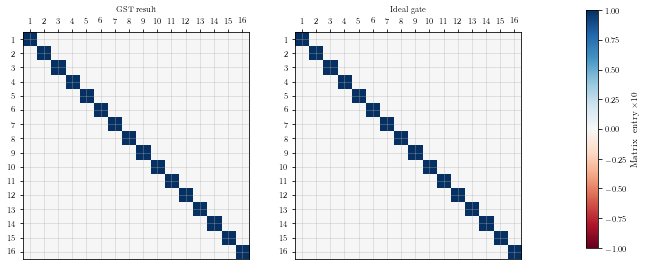

In [14]:
# Standard basis
plot_mat(X_opt[5]@X_t[5].T.conj(), X_t[5]@X_t[5].T.conj())

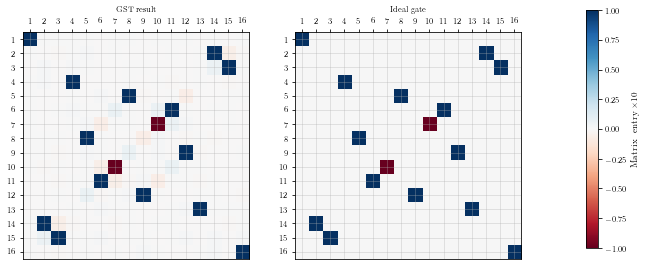

In [13]:
# Pauli basis:
X_opt_pp, E_opt_pp, rho_opt_pp = compatibility.std2pp(X_opt, E_opt, rho_opt)
X_t_pp, E_t_pp, rho_t_pp = compatibility.std2pp(X_t, E_t, rho_t)
plot_mat(X_opt_pp[5], X_t_pp[5])

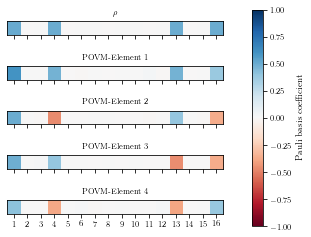

In [19]:
# SPAM in Pauli basis
plot_spam(rho_opt_pp, E_opt_pp)

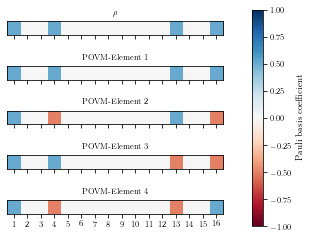

In [20]:
# Ideal SPAM in Pauli basis
plot_spam(rho_t_pp, E_t_pp)

Assignment fidelity for ideal basis state 0: 0.9125360253384016


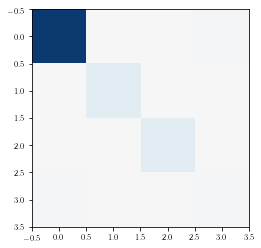

Assignment fidelity for ideal basis state 1: 0.7465329376809569


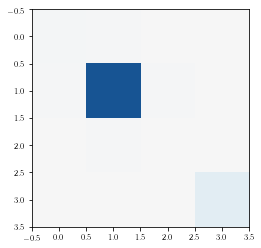

Assignment fidelity for ideal basis state 2: 0.738572079996279


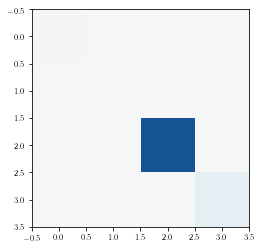

Assignment fidelity for ideal basis state 3: 0.6175686646054579


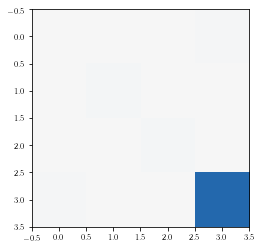

In [15]:
# POVM in standard basis
for i in range(4):
    print("Assignment fidelity for ideal basis state %i:"%i, np.abs(E_opt.reshape(4,4,4)[i,i,i])**2)
    plt.imshow(np.abs(E_opt.reshape(4,4,4)[i,:,:]), vmin = -1, vmax = 1)
    plt.show()

0.0
0.07277897342891491
0.07419979842374834
-3.0154233818546756


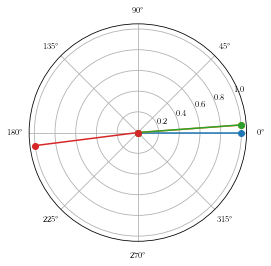

In [18]:
# Angles
K_t = additional_fns.Kraus_rep(X_t,d,pdim,1)
K_opt = additional_fns.Kraus_rep(X_opt,d,pdim,1)

for x in np.diag(K_opt[5][0]):
    print(np.angle(x))
    plt.polar([0,np.angle(x)],[0,abs(x)],marker='o')
plt.show()

## Rank 2 analysis

In [23]:
with open('rank_2_hardware_probs_1313', 'rb') as handle:
    b = pickle.load(handle)
results = b['results']
K,X,E,rho = results[0][:]
J = b['parameters']['J']
y = b['parameters']['y']

In [24]:
weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 0, 'rho0': 100}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)

df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, target_mdl, gate_labels)
display(s_g), display(s_o)

,F_avg,Diamond distances,Min. Spectral distances
Id,"0,98926","0,04526","0,02889"
Rx(pi/2)[q0],"0,98926","0,03919","0,01682"
Ry(pi/2)[q0],"0,98999","0,04101","0,01877"
Rx(pi/2)[q1],"0,98979","0,03186","0,01724"
Ry(pi/2)[q1],"0,98685","0,03763","0,01993"
CZ[q0-q1],"0,96317","0,13977","0,08653"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000289,0.019797,0.081364,0.061603,0.000375


(None, None)

## Rank 16 Analysis

In [31]:
with open('rank_16_hardware_probs_1313', 'rb') as handle:
    b = pickle.load(handle)
results = b['results']
K,X,E,rho = results[0][:]
J = b['parameters']['J']
y = b['parameters']['y']

In [32]:
weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 0, 'rho0': 100}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)

df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J, y, target_mdl, gate_labels)
display(s_g), display(s_o)

,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99972","0,02140","0,01991"
Rx(pi/2)[q0],"0,99976","0,02271","0,00964"
Ry(pi/2)[q0],"0,99976","0,02272","0,00910"
Rx(pi/2)[q1],"0,99985","0,01818","0,00890"
Ry(pi/2)[q1],"0,99984","0,01891","0,00636"
CZ[q0-q1],"0,99825","0,06538","0,04994"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000515,0.027359,0.081364,0.095886,0.000506


(None, None)

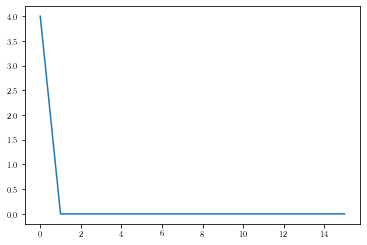

In [29]:
# Spectrum of the Choi matrix
X_choi = X_opt.reshape(d,pdim,pdim,pdim,pdim)
X_choi = np.einsum('ijklm->iljmk',X_choi).reshape(d,pdim**2,pdim**2)
plt.plot(np.sort(np.abs(la.eig(X_choi[5])[0]))[::-1])

In [30]:
print(np.sort(np.abs(la.eig(X_choi[5])[0]))[::-1])

[4.00000000e+00 2.96862178e-15 4.24982942e-16 3.83907075e-16
 3.67281825e-16 3.02125323e-16 1.67107590e-16 1.66312446e-16
 1.58091371e-16 9.87890861e-17 6.53061446e-17 6.49308615e-17
 3.28322301e-17 2.80173436e-17 1.93920726e-17 1.50486630e-17]
